# Практичне завдання з аналізу часових рядів
## Використання ARIMA, Random Forest, LSTM та GRU для прогнозування

In [1]:
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Встановлення стилю для графіків
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 1. Генерація синтетичного часового ряду для демонстрації

In [4]:
def generate_time_series(n_samples=1000):
    np.random.seed(42)
    # Створення часового індексу
    date_rng = pd.date_range(start='2020-01-01', periods=n_samples, freq='D')
    
    # Генерація тренду
    trend = np.linspace(0, 15, n_samples)
    
    # Генерація сезонності
    seasonality = 5 * np.sin(np.linspace(0, 12*2*np.pi, n_samples))
    
    # Додавання шуму
    noise = np.random.normal(0, 1, n_samples)
    
    # Комбінування компонентів
    value = trend + seasonality + noise
    
    # Створення DataFrame
    df = pd.DataFrame(date_rng, columns=['date'])
    df['value'] = value
    df.set_index('date', inplace=True)
    
    # Додавання деяких пропущених значень для демонстрації передобробки
    random_indices = np.random.choice(range(len(df)), size=20, replace=False)
    df.iloc[random_indices, 0] = np.nan
    
    return df

In [5]:
# Генерація даних
df = generate_time_series()

# Збереження даних у CSV для подальшого використання
df.to_csv('time_series_data.csv')

# Перегляд перших рядків даних
df.head()

,value
date,
2020-01-01,0.496714
2020-01-02,0.253761
2020-01-03,1.429593
2020-01-04,2.690532
2020-01-05,1.312556


## Передобробка даних

In [6]:
print("Кількість пропущених значень:", df.isnull().sum()[0])

# Заповнення пропущених значень методом лінійної інтерполяції
df.fillna(method="ffill", inplace=True)
print("Після заповнення пропущених значень:", df.isnull().sum()[0])

Кількість пропущених значень: 20
Після заповнення пропущених значень: 0


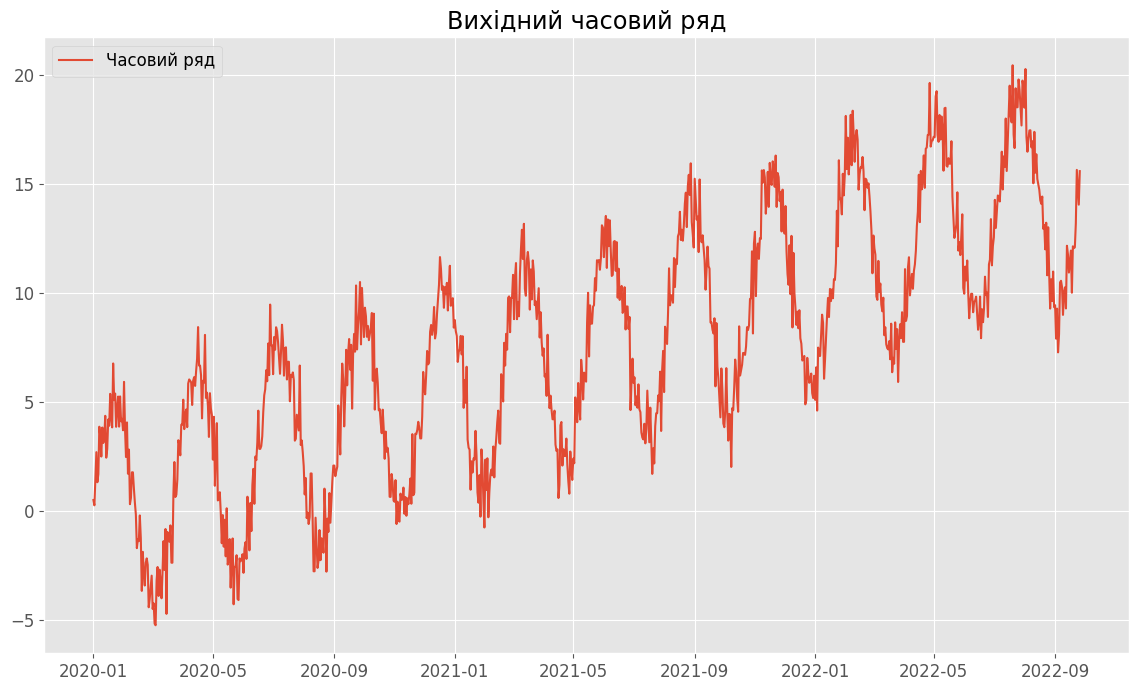

In [7]:
# Візуалізація часового ряду
plt.figure(figsize=(14, 8))
plt.plot(df["value"], label="Часовий ряд")
plt.title("Вихідний часовий ряд")
plt.legend()
plt.show()

## 2. Використання ARIMA для прогнозування тренду часового ряду

In [8]:
# Розбиття на тренувальну та тестову вибірки
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Побудова моделі ARIMA
model = ARIMA(train["value"], order=(5, 1, 0))  # (p,d,q) - параметри моделі
model_fit = model.fit()

# Прогнозування
forecast = model_fit.forecast(steps=len(test))
test["forecast_ARIMA"] = forecast

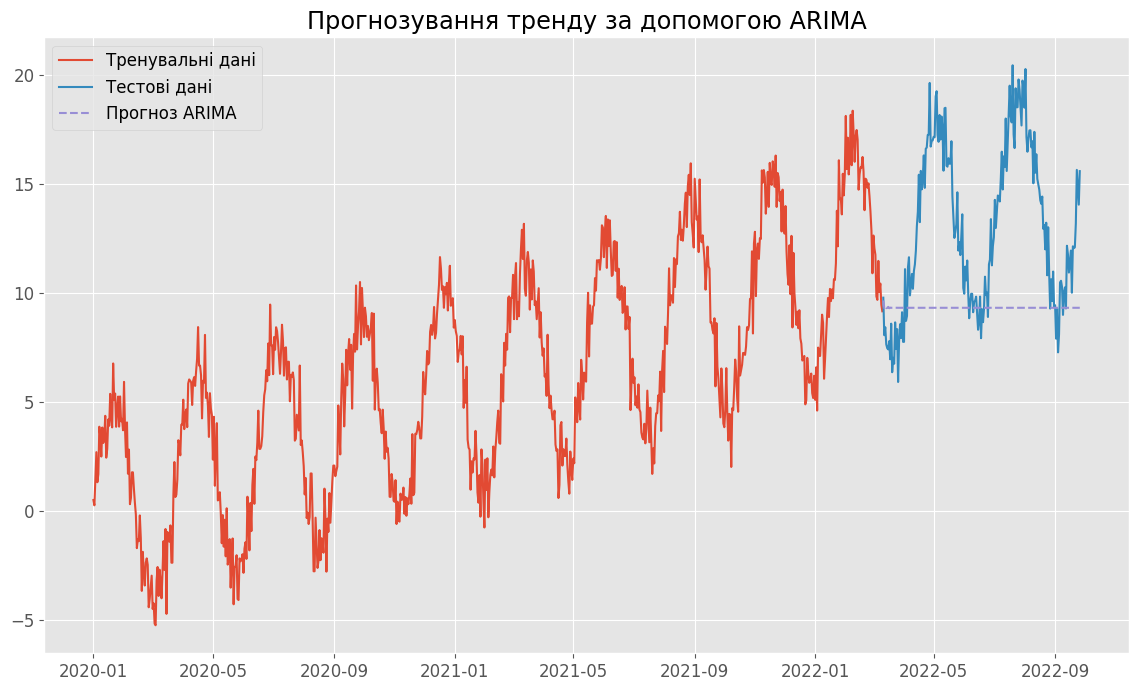

In [9]:
# Візуалізація результатів
plt.figure(figsize=(14, 8))
plt.plot(train["value"], label="Тренувальні дані")
plt.plot(test["value"], label="Тестові дані")
plt.plot(test["forecast_ARIMA"], label="Прогноз ARIMA", linestyle="dashed")
plt.title("Прогнозування тренду за допомогою ARIMA")
plt.legend()
plt.show()

In [10]:
# Оцінка якості прогнозу ARIMA
arima_mse = np.mean((test["value"] - test["forecast_ARIMA"]) ** 2)
print(f"ARIMA MSE: {arima_mse:.4f}")

ARIMA MSE: 27.4551


## 3. Використання Random Forest для аналізу сезонності

In [11]:
# Створення нових ознак (лагів)
df_rf = df.copy()
df_rf["lag1"] = df_rf["value"].shift(1)
df_rf["lag2"] = df_rf["value"].shift(2)
df_rf["lag3"] = df_rf["value"].shift(3)
df_rf["lag4"] = df_rf["value"].shift(4)
df_rf["lag5"] = df_rf["value"].shift(5)
df_rf["lag6"] = df_rf["value"].shift(6)
df_rf["lag7"] = df_rf["value"].shift(7)  # Тижневий лаг для виявлення тижневої сезонності
df_rf["lag30"] = df_rf["value"].shift(30)  # Місячний лаг для виявлення місячної сезонності
df_rf.dropna(inplace=True)

# Додавання циклічних ознак для кращого виявлення сезонності
df_rf['month'] = df_rf.index.month
df_rf['day_of_week'] = df_rf.index.dayofweek
df_rf['day_of_year'] = df_rf.index.dayofyear

In [12]:
# Розбиття на тренувальну та тестову вибірки
X = df_rf.drop(columns=["value"])
y = df_rf["value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Побудова моделі Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Прогнозування
y_pred_rf = model_rf.predict(X_test)

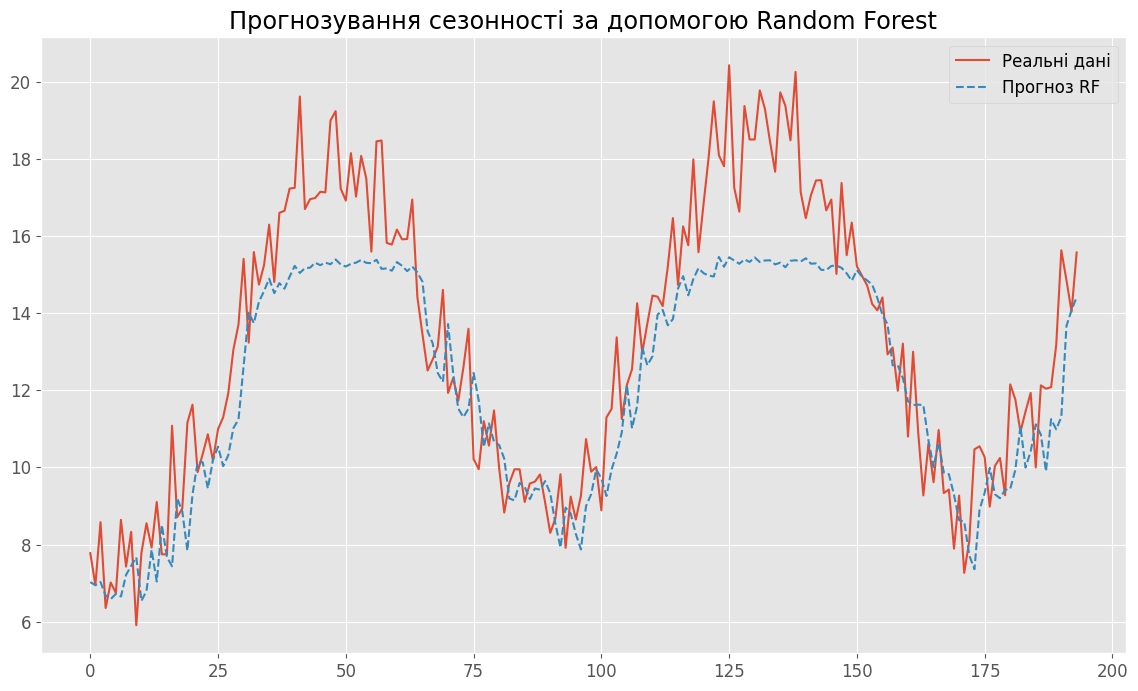

In [13]:
# Візуалізація
plt.figure(figsize=(14, 8))
plt.plot(y_test.values, label="Реальні дані")
plt.plot(y_pred_rf, label="Прогноз RF", linestyle="dashed")
plt.title("Прогнозування сезонності за допомогою Random Forest")
plt.legend()
plt.show()

In [14]:
# Оцінка якості прогнозу Random Forest
rf_mse = np.mean((y_test - y_pred_rf) ** 2)
print(f"Random Forest MSE: {rf_mse:.4f}")

Random Forest MSE: 3.4097


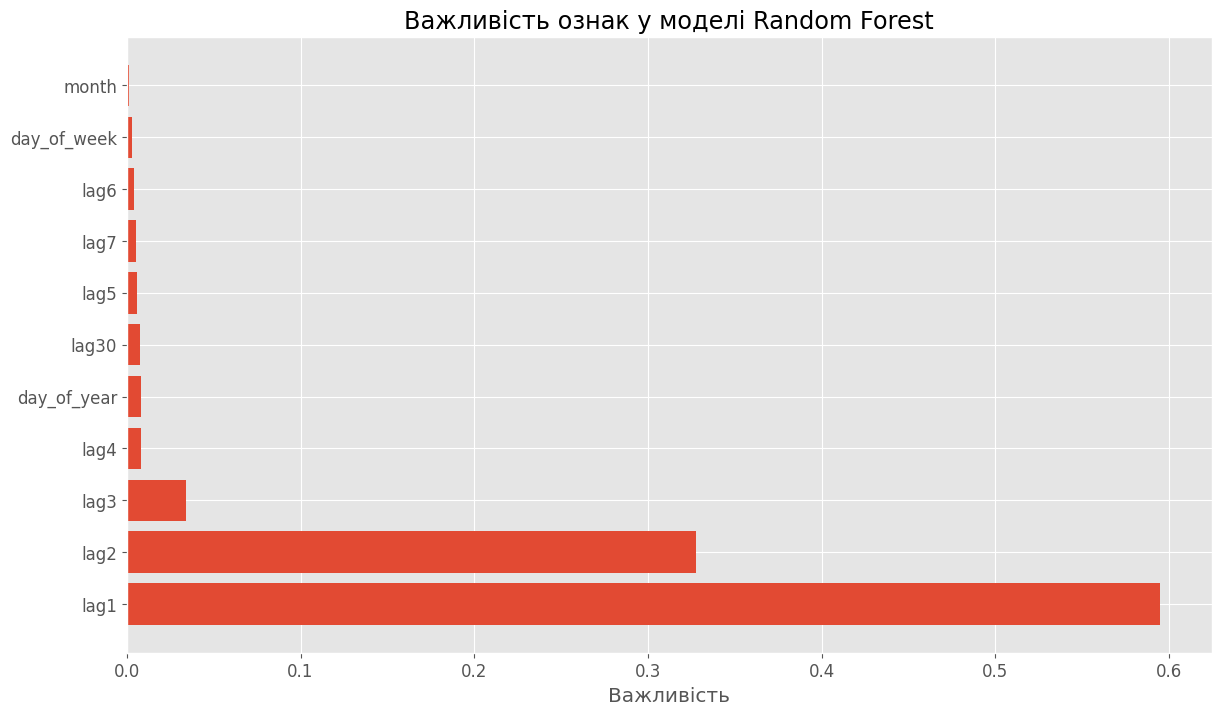

Важливість ознак для виявлення сезонності:


,Feature,Importance
0,lag1,0.594973
1,lag2,0.327712
2,lag3,0.034220
3,lag4,0.008318
10,day_of_year,0.008019
7,lag30,0.007688
4,lag5,0.005697
6,lag7,0.005190
5,lag6,0.003873
9,day_of_week,0.002890


In [15]:
# Аналіз важливості ознак для виявлення сезонності
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Важливість ознак у моделі Random Forest')
plt.xlabel('Важливість')
plt.show()

print("Важливість ознак для виявлення сезонності:")
feature_importance.head(10)

## 4. Навчання LSTM на наборі даних

In [16]:
# Нормалізація даних
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["value"]])

# Підготовка даних для LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Використання 30 днів для прогнозування наступного дня
X, y = create_sequences(df_scaled, seq_length)

# Розбиття на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
# Побудова LSTM моделі
model_lstm = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.1504 - val_loss: 0.0175
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0039 - val_loss: 0.0068
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0030 - val_loss: 0.0076
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0

In [18]:
# Прогнозування
y_pred_lstm = model_lstm.predict(X_test)

# Перетворення назад до оригінального масштабу
y_test_inv = scaler.inverse_transform(y_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step


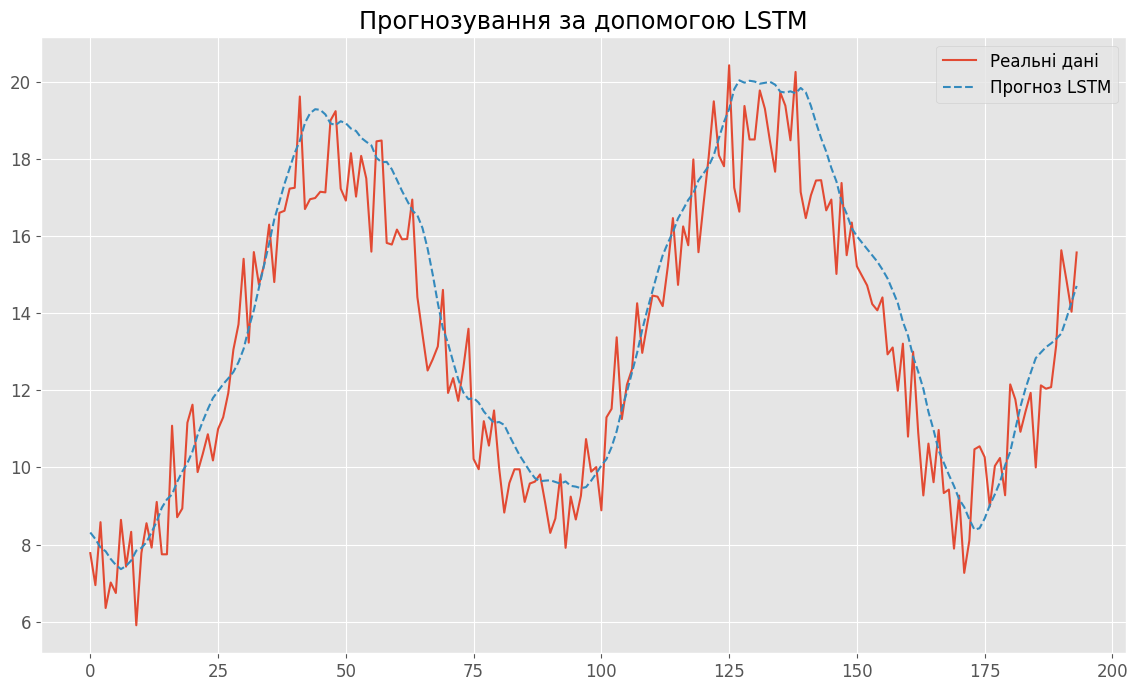

In [19]:
# Візуалізація результатів
plt.figure(figsize=(14, 8))
plt.plot(y_test_inv, label="Реальні дані")
plt.plot(y_pred_lstm_inv, label="Прогноз LSTM", linestyle="dashed")
plt.title("Прогнозування за допомогою LSTM")
plt.legend()
plt.show()

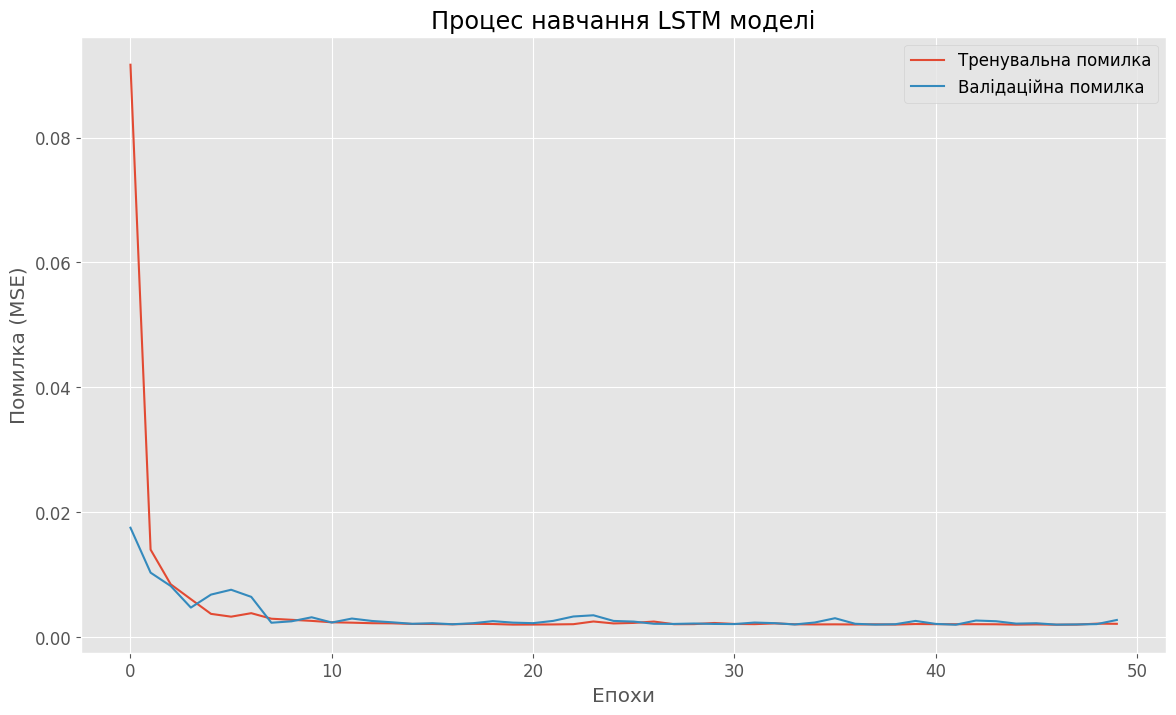

In [20]:
# Візуалізація процесу навчання LSTM
plt.figure(figsize=(14, 8))
plt.plot(history_lstm.history['loss'], label='Тренувальна помилка')
plt.plot(history_lstm.history['val_loss'], label='Валідаційна помилка')
plt.title('Процес навчання LSTM моделі')
plt.xlabel('Епохи')
plt.ylabel('Помилка (MSE)')
plt.legend()
plt.show()

In [21]:
# Оцінка якості прогнозу LSTM
lstm_mse = np.mean((y_test_inv - y_pred_lstm_inv) ** 2)
print(f"LSTM MSE: {lstm_mse:.4f}")

LSTM MSE: 1.7411


## 5. Використання GRU для прогнозування майбутніх значень

In [22]:
# Побудова GRU моделі
model_gru = Sequential([
    GRU(50, activation="relu", return_sequences=True, input_shape=(seq_length, 1)),
    GRU(50, activation="relu"),
    Dense(1)
])

model_gru.compile(optimizer="adam", loss="mse")
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - loss: 0.1746 - val_loss: 0.1214
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0261 - val_loss: 0.0165
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.

In [23]:
# Прогнозування
y_pred_gru = model_gru.predict(X_test)

# Перетворення назад до оригінального масштабу
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


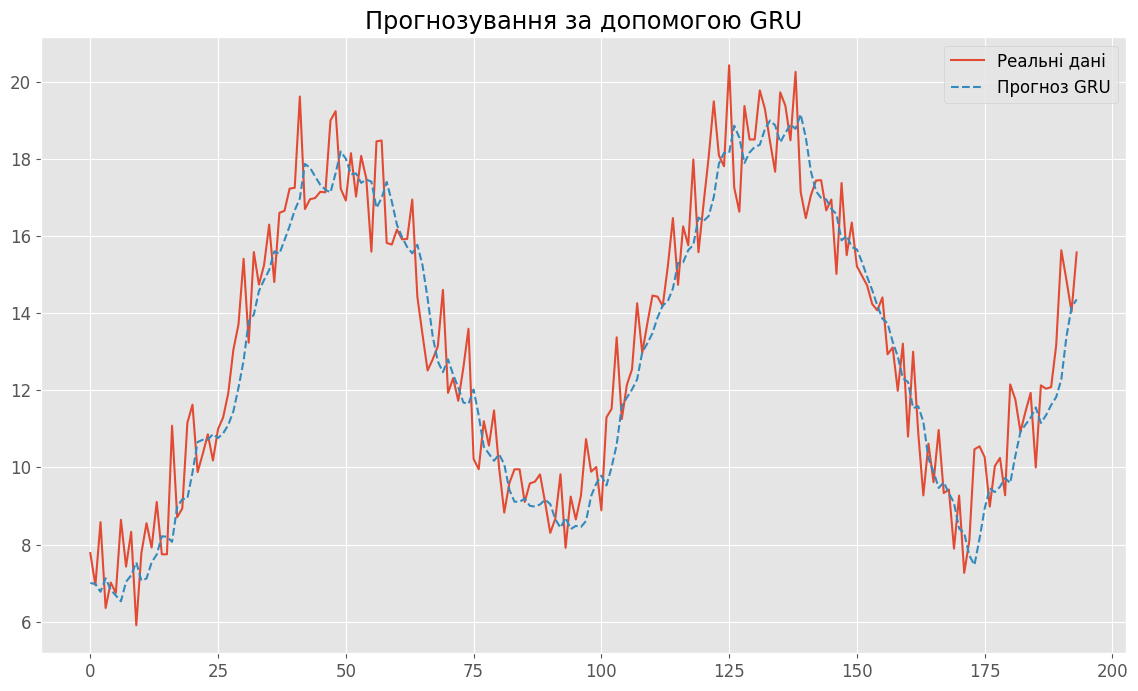

In [24]:
# Візуалізація результатів
plt.figure(figsize=(14, 8))
plt.plot(y_test_inv, label="Реальні дані")
plt.plot(y_pred_gru_inv, label="Прогноз GRU", linestyle="dashed")
plt.title("Прогнозування за допомогою GRU")
plt.legend()
plt.show()

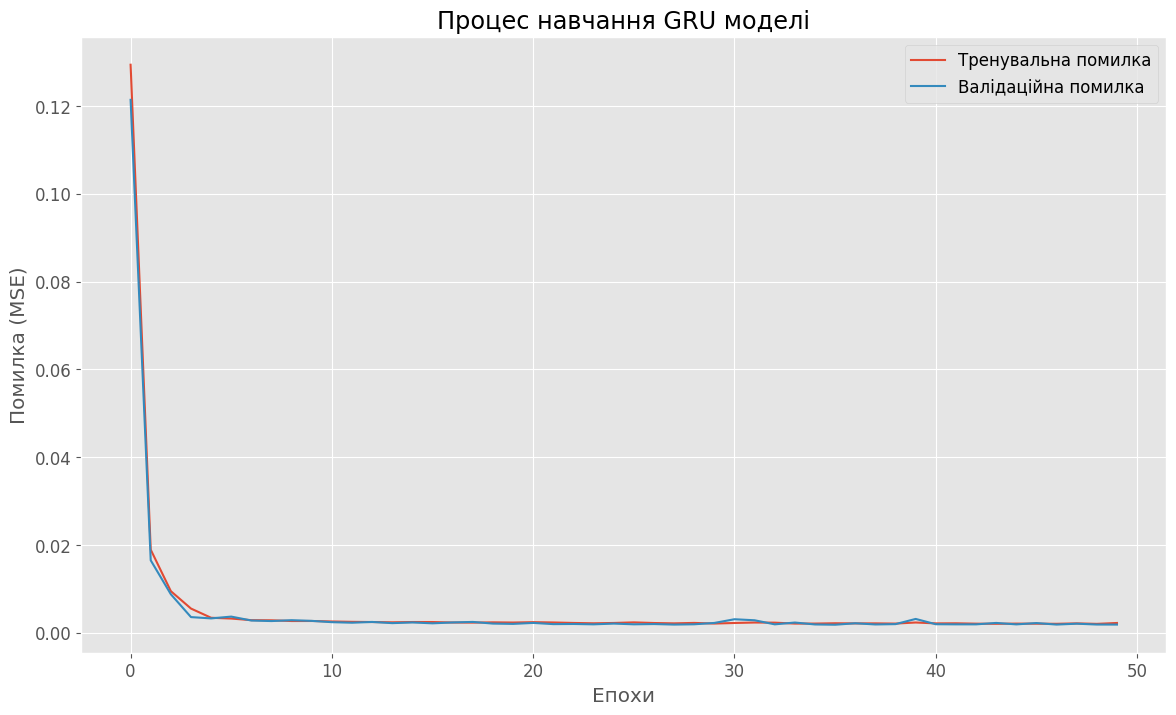

In [25]:
# Візуалізація процесу навчання GRU
plt.figure(figsize=(14, 8))
plt.plot(history_gru.history['loss'], label='Тренувальна помилка')
plt.plot(history_gru.history['val_loss'], label='Валідаційна помилка')
plt.title('Процес навчання GRU моделі')
plt.xlabel('Епохи')
plt.ylabel('Помилка (MSE)')
plt.legend()
plt.show()

In [26]:
# Оцінка якості прогнозу GRU
gru_mse = np.mean((y_test_inv - y_pred_gru_inv) ** 2)
print(f"GRU MSE: {gru_mse:.4f}")

GRU MSE: 1.4019


## 6. Порівняння всіх моделей

In [27]:
# Створення DataFrame для порівняння
comparison = pd.DataFrame({
    'Модель': ['ARIMA', 'Random Forest', 'LSTM', 'GRU'],
    'MSE': [arima_mse, rf_mse, lstm_mse, gru_mse]
})

comparison.sort_values('MSE')

,Модель,MSE
3,GRU,1.401866
2,LSTM,1.741052
1,Random Forest,3.409701
0,ARIMA,27.455067


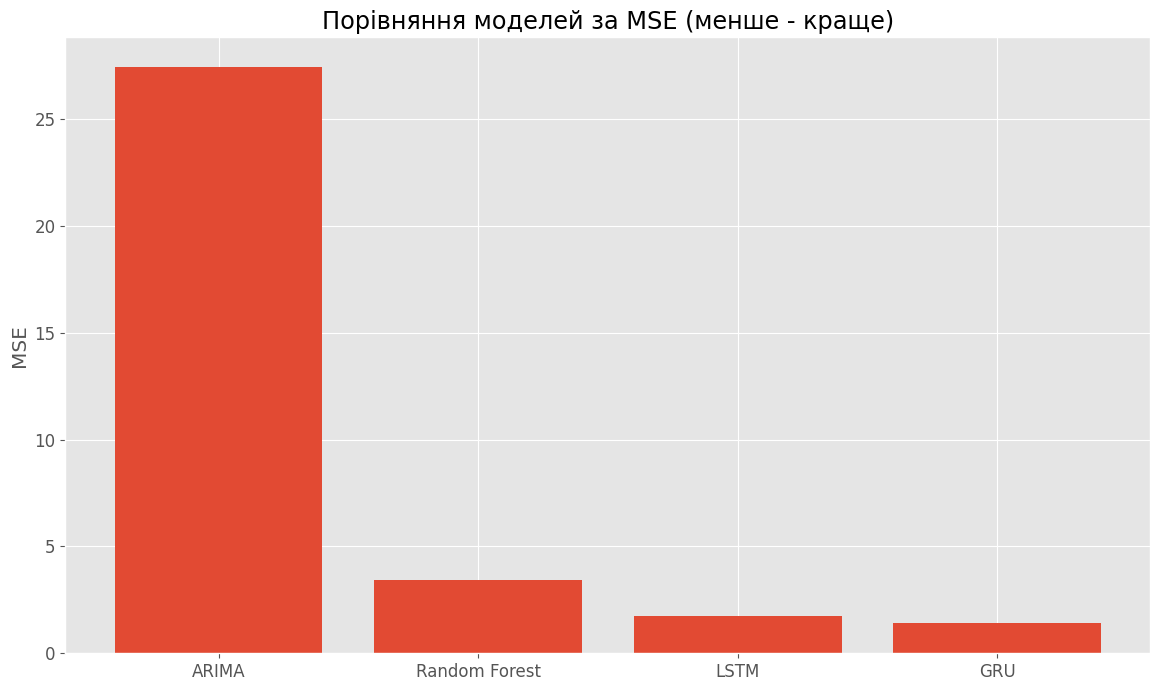


Аналіз завершено. Результати відображено у вигляді графіків.


In [28]:
# Візуалізація порівняння моделей
plt.figure(figsize=(14, 8))
plt.bar(comparison['Модель'], comparison['MSE'])
plt.title('Порівняння моделей за MSE (менше - краще)')
plt.ylabel('MSE')
plt.show()

print("\nАналіз завершено. Результати відображено у вигляді графіків.")